In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("xgboost is not installed. Install it with `pip install xgboost` if you want to run the XGBoost section.")

# Optional: TensorFlow / Keras for the MLP
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow is not installed. Install it with `pip install tensorflow` to run the neural network section.")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


/tmp/ipykernel_3383/4105545737.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


xgboost is not installed. Install it with `pip install xgboost` if you want to run the XGBoost section.


2025-12-08 21:45:29.216136: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 21:45:29.278971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-08 21:45:29.279056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-08 21:45:29.281965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-08 21:45:29.293649: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-08 21:45:29.294740: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import pandas as pd

# Path to dataset folder
DATA_PATH = "./data/"

# Column names from adult.names
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country",
    "income"
]

# --- Load training set ---
df_train = pd.read_csv(
    DATA_PATH + "adult.data",
    header=None,
    names=columns,
    na_values=["?"],
    skipinitialspace=True
)

# --- Load test set ---
df_test = pd.read_csv(
    DATA_PATH + "adult.test",
    header=0,               # first line is " |1x3 Cross validator"
    names=columns,
    na_values=["?"],
    skipinitialspace=True,
    comment="|"             # removes weird test header lines
)

# Fix labels in test (">50K." → ">50K")
df_test["income"] = df_test["income"].str.replace(".", "", regex=False)

# Combine training + test
df = pd.concat([df_train, df_test], ignore_index=True)

print("Combined shape:", df.shape)

# Save clean file
df.to_csv(DATA_PATH + "adult.csv", index=False)

df.head()


Combined shape: (48841, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
DATA_PATH = "./data/adult.csv"

df = pd.read_csv(DATA_PATH, na_values=["?"])
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Inspect columns
print(df.columns)

# Strip whitespace from string columns
str_cols = df.select_dtypes(include=["object"]).columns
df[str_cols] = df[str_cols].apply(lambda s: s.str.strip())

# Standardize the target column name and values
TARGET_COL = "income"
if TARGET_COL not in df.columns:
    raise ValueError(f"Expected target column '{TARGET_COL}' not found. Check your CSV headers.")

# Remove trailing periods in the labels (e.g., '>50K.' -> '>50K')
df[TARGET_COL] = df[TARGET_COL].str.replace(".", "", regex=False)

print(df[TARGET_COL].value_counts())

# Handle missing values: for simplicity, drop rows with NaNs
before = df.shape[0]
df = df.dropna().reset_index(drop=True)
after = df.shape[0]
print(f"Dropped {before - after} rows with missing values. New shape: {df.shape}")


Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')
income
<=50K    37154
>50K     11687
Name: count, dtype: int64
Dropped 3620 rows with missing values. New shape: (45221, 15)


In [5]:
FEATURE_COLS = [c for c in df.columns if c != TARGET_COL]

X = df[FEATURE_COLS]
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True))


Train shape: (31654, 14) Test shape: (13567, 14)
Train class distribution:
income
<=50K    0.752164
>50K     0.247836
Name: proportion, dtype: float64


In [6]:
# Identify numeric and categorical features
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Preprocessor: one-hot encode categorical, pass numeric through for tree models
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
results = []

Numeric features: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [7]:
def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Fits are assumed already done.
    Returns a dict of metrics and plots confusion matrix.
    """
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    # Positive class is '>50K'
    prec = precision_score(y_test, y_pred, pos_label=">50K")
    rec = recall_score(y_test, y_pred, pos_label=">50K")
    f1 = f1_score(y_test, y_pred, pos_label=">50K")

    print(f"=== {model_name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred, labels=["<=50K", ">50K"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
    disp.plot()
    plt.title(f"{model_name} – Confusion Matrix")
    plt.show()

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }


=== Random Forest (baseline) ===
Accuracy : 0.8497
Precision: 0.7321
Recall   : 0.6209
F1-score : 0.6719


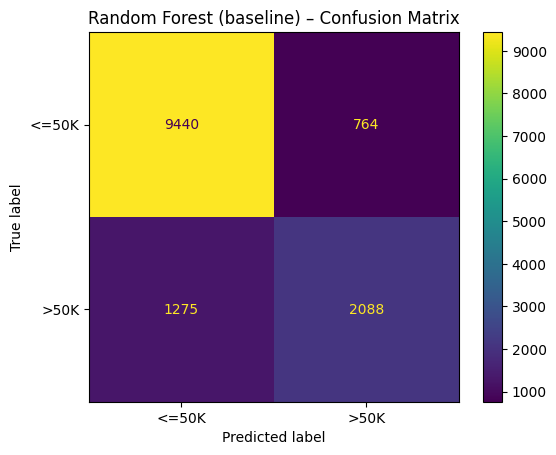

In [8]:
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                random_state=RANDOM_STATE,
                n_jobs=-1,
            ),
        ),
    ]
)

rf_clf.fit(X_train, y_train)
results.append(evaluate_classifier(rf_clf, X_test, y_test, "Random Forest (baseline)"))


In [9]:
if XGBOOST_AVAILABLE:
    xgb_clf = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            (
                "clf",
                XGBClassifier(
                    n_estimators=300,
                    learning_rate=0.1,
                    max_depth=5,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective="binary:logistic",
                    eval_metric="logloss",
                    random_state=RANDOM_STATE,
                    n_jobs=-1,
                ),
            ),
        ]
    )

    xgb_clf.fit(X_train, y_train)
    results.append(evaluate_classifier(xgb_clf, X_test, y_test, "XGBoost (baseline)"))
else:
    print("Skipping XGBoost model; xgboost package not installed.")


Skipping XGBoost model; xgboost package not installed.


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF params: {'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
Best RF CV F1: 0.685317280742554
=== Random Forest (tuned) ===
Accuracy : 0.8545
Precision: 0.7750
Recall   : 0.5819
F1-score : 0.6647


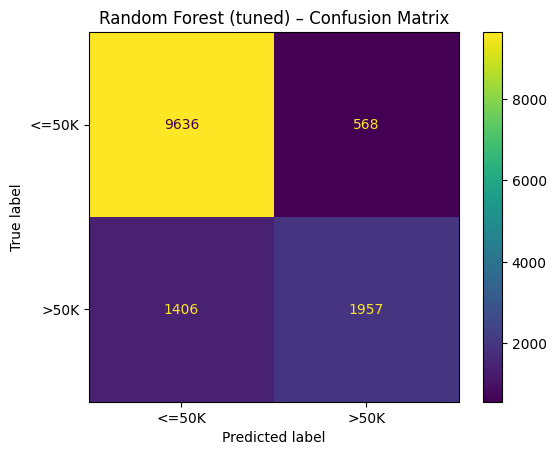

In [10]:
rf_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
}

f1_pos_scorer = make_scorer(f1_score, pos_label=">50K")

rf_grid = GridSearchCV(
    rf_clf,
    param_grid=rf_param_grid,
    cv=3,
    scoring=f1_pos_scorer, 
    n_jobs=-1,
    verbose=1,
)


rf_grid.fit(X_train, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV F1:", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_
results.append(evaluate_classifier(best_rf, X_test, y_test, "Random Forest (tuned)"))


In [12]:
if TF_AVAILABLE:
    # Fit the preprocessor on training data only
    preprocessor_nn = preprocessor  # reuse the same definition

    X_train_enc = preprocessor_nn.fit_transform(X_train)
    X_test_enc = preprocessor_nn.transform(X_test)

    # Convert sparse to dense
    X_train_dense = X_train_enc.toarray()
    X_test_dense = X_test_enc.toarray()

    # Standardize features (especially beneficial for neural networks)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_dense)
    X_test_scaled = scaler.transform(X_test_dense)

    input_dim = X_train_scaled.shape[1]
    print("NN input dimension:", input_dim)
else:
    print("TensorFlow not available; skipping NN preprocessing.")


NN input dimension: 104


In [13]:
# Only run if TensorFlow is installed
if TF_AVAILABLE:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.optimizers import Adam

    input_dim = X_train_scaled.shape[1]

    mlp_model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),
    ])

    mlp_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    # Train
    history = mlp_model.fit(
        X_train_scaled,
        (y_train == ">50K").astype(int),  # convert labels → 0/1
        validation_split=0.2,
        epochs=10,
        batch_size=32,
        verbose=1,
    )


Epoch 1/10
792/792 [==============================] - 2s 2ms/step - loss: 0.3650 - accuracy: 0.8307 - val_loss: 0.3348 - val_accuracy: 0.8462
Epoch 2/10
792/792 [==============================] - 1s 2ms/step - loss: 0.3239 - accuracy: 0.8510 - val_loss: 0.3301 - val_accuracy: 0.8480
Epoch 3/10
792/792 [==============================] - 1s 2ms/step - loss: 0.3127 - accuracy: 0.8561 - val_loss: 0.3305 - val_accuracy: 0.8484
Epoch 4/10
792/792 [==============================] - 1s 2ms/step - loss: 0.3075 - accuracy: 0.8575 - val_loss: 0.3302 - val_accuracy: 0.8480
Epoch 5/10
792/792 [==============================] - 1s 2ms/step - loss: 0.3030 - accuracy: 0.8595 - val_loss: 0.3337 - val_accuracy: 0.8465
Epoch 6/10
792/792 [==============================] - 1s 2ms/step - loss: 0.2985 - accuracy: 0.8636 - val_loss: 0.3338 - val_accuracy: 0.8450
Epoch 7/10
792/792 [==============================] - 1s 2ms/step - loss: 0.2952 - accuracy: 0.8648 - val_loss: 0.3346 - val_accuracy: 0.8487
Epoch 

In [14]:
def get_feature_names(preprocessor, numeric_features, categorical_features):
    """
    Helper to get the expanded feature names after one-hot encoding.
    """
    # Order must match ColumnTransformer
    feature_names = []

    # Numeric features (passthrough)
    feature_names.extend(numeric_features)

    # Categorical features (OneHotEncoder)
    ohe = preprocessor.named_transformers_["cat"]
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names.tolist())

    return feature_names

# Use tuned RF if it exists, otherwise baseline
rf_to_use = "best_rf" in globals() and best_rf or rf_clf

rf_preprocessor = rf_to_use.named_steps["preprocess"]
rf_model = rf_to_use.named_steps["clf"]

feature_names = get_feature_names(rf_preprocessor, numeric_features, categorical_features)
importances = rf_model.feature_importances_

# Put into DataFrame
feat_imp_df = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values("importance", ascending=False)

feat_imp_df.head(20)


if XGBOOST_AVAILABLE:
    xgb_preprocessor = xgb_clf.named_steps["preprocess"]
    xgb_model = xgb_clf.named_steps["clf"]

    xgb_feature_names = get_feature_names(xgb_preprocessor, numeric_features, categorical_features)
    xgb_importances = xgb_model.feature_importances_

    xgb_feat_imp_df = pd.DataFrame(
        {"feature": xgb_feature_names, "importance": xgb_importances}
    ).sort_values("importance", ascending=False)

    xgb_feat_imp_df.head(20)


In [15]:
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


,model,accuracy,precision,recall,f1
0,Random Forest (baseline),0.849709,0.732118,0.620874,0.671923
1,Random Forest (tuned),0.854500,0.775050,0.581921,0.664742


In [16]:
if TF_AVAILABLE:
    # Predict probabilities and threshold at 0.5
    y_pred_prob = mlp_model.predict(X_test_scaled).ravel()
    y_pred_bin = (y_pred_prob >= 0.5).astype(int)

    # Map 0/1 back to labels
    y_pred_labels = np.where(y_pred_bin == 1, ">50K", "<=50K")

    acc = accuracy_score(y_test, y_pred_labels)
    prec = precision_score(y_test, y_pred_labels, pos_label=">50K")
    rec = recall_score(y_test, y_pred_labels, pos_label=">50K")
    f1 = f1_score(y_test, y_pred_labels, pos_label=">50K")

    print("=== Neural Network (MLP) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    results.append(
        {
            "model": "Neural Network (MLP)",
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
        }
    )
else:
    print("TensorFlow not available; skipping NN evaluation.")


424/424 [==============================] - 0s 774us/step
=== Neural Network (MLP) ===
Accuracy : 0.8436
Precision: 0.7176
Recall   : 0.6084
F1-score : 0.6585


In [17]:
results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
results_df


,model,accuracy,precision,recall,f1
0,Random Forest (baseline),0.849709,0.732118,0.620874,0.671923
1,Random Forest (tuned),0.854500,0.775050,0.581921,0.664742
2,Neural Network (MLP),0.843591,0.717643,0.608385,0.658513
